In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os
import copy

# Note: Model name used in paper and in code (here) are different.
# NNPhD -> SUPERLNN
# UAN -> BASE

In [2]:
class LNN(nn.Module):
    def __init__(self, d = 2, w=200):
        super(LNN, self).__init__()
        
        self.d = d
        self.l11 = nn.Linear(2*d,w)
        self.l12 = nn.Linear(2*d,w)
        self.l13 = nn.Linear(2*d,w)
        self.l3 = nn.Linear(2*w,1)
        
    def forward(self, x):
        self.x12 = self.l12(x)**2
        self.x13 = self.l13(x)
        self.x1 = torch.cat([self.x12,self.x13],dim=1)
        self.x3 = self.l3(self.x1)
        return self.x3
    
    def Lq(self, y, x):
        grads = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
        return grads

    def Lqq(self, y, x):
        grads = self.Lq(y, x)
        ggs = []
        shp = grads.shape
        for i in range(shp[0]):
            gg = []
            for j in range(shp[1]):
                g = torch.autograd.grad(grads[i,j], x, torch.tensor(1.), create_graph=True, retain_graph=True)[0][i]
                gg.append(g)
            gg = torch.stack(gg)
            ggs.append(gg)
        return torch.stack(ggs)

    def qtt(self, Lqq_, Lq_, qt_):
        a = torch.tensor(1, dtype=torch.float)
        a = Variable(a, requires_grad=True)
        Lvv = Lqq_[:,self.d:2*self.d,self.d:2*self.d] + a
        Lxv = Lqq_[:,self.d:2*self.d,0:self.d]
        result = torch.matmul(torch.inverse(Lvv), torch.unsqueeze(Lq_[:,0:self.d],dim=2)-torch.matmul(Lxv,torch.unsqueeze(qt_,dim=2)))
        return result
    
    def predict(self, x):
        outputs = self.forward(x)
        Lqq_ = self.Lqq(outputs,x)
        Lq_ = self.Lq(outputs,x)
        qt_ = Variable(x[:,self.d:2*self.d],requires_grad=True)
        qtt_pred = self.qtt(Lqq_, Lq_, qt_)
        return qtt_pred

class BASE(nn.Module):
    def __init__(self, d = 2, w=200, mode="0"):
        super(BASE, self).__init__()
        self.mode = mode
        self.d = d
        if mode == "t":
            self.l1 = nn.Linear(1,w)
        elif mode == "qq":
            self.l1 = nn.Linear(2*d,w)
        elif mode == "qqt":
            self.l1 = nn.Linear(2*d+1,w)
        self.l2 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,d)
        
    def forward(self, x):
        act = "relu"
        #f = F.relu
        f = nn.LeakyReLU(0.1)
        
        if self.mode == "t":
            self.x1 = f(self.l1(torch.unsqueeze(x[:,-1],dim=1)))
        elif self.mode == "qq":
            self.x1 = f(self.l1(x[:,:2*self.d]))
        elif self.mode == "qqt":
            self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        return self.x3

class SUPERLNN(nn.Module):
    def __init__(self, d = 2, w=200, mode="0"):
        super(SUPERLNN, self).__init__()
        self.lnn = LNN(d=d)
        self.d = d
        self.base = BASE(d=d, mode=mode)
        self.mode = mode
            
    def forward(self, x):
        self.x1 = self.lnn(x[:,:2*self.d])
        if self.mode == "0":
            return self.x1
        else:
            self.x2 = self.base(x)
            return self.x1 + self.x2
        
# data
n_train = 100
d = 1
x = torch.normal(0,1,size=(n_train,2*d+1))
x = Variable(x, requires_grad=True)
y = -x[:,0]-0.5*x[:,1]



In [3]:
#modes = ["qqt","qq","t","0"]
modes = ["qqt"]

batch_size = 32
log = 10
lrs = [1e-2,1e-3,1e-4,1e-5]

for j in range(len(modes)):
    np.random.seed(0)
    torch.manual_seed(0)
    loss_qtts = []
    mode = modes[j]
    print("***************mode={}***************".format(mode))
    superlnn = SUPERLNN(d=1, mode=mode)
    epochs = 1000
    if mode == "0":
        lambs = [0]
    else:
        lambs = [0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50,100]
        #lambs = [0]
    for i in range(len(lambs)):
        lamb = lambs[i]
        print("--------------lamb={}-------------".format(lamb))
        for epoch in range(epochs):
            if epoch % int(epochs/4) == 0:
                idd = int(np.ceil(4*epoch/epochs))
                optimizer = optim.Adam(superlnn.parameters(), lr = lrs[idd])
            superlnn.train()
            optimizer.zero_grad()
            if epoch < epochs-1:
                choices = np.random.choice(n_train, batch_size)
            else:
                choices = np.arange(n_train)
            inputs = torch.tensor(x[choices] ,dtype=torch.float, requires_grad=True)
            labels = torch.tensor(y[choices] ,dtype=torch.float, requires_grad=True)
            # LNN predict
            lnn_pred = superlnn.lnn.predict(inputs[:,:2*superlnn.d])[:,:,0]
            # Base predict
            if mode == "0":
                loss = loss_qtt
            else:
                base_pred = superlnn.base(inputs)
                qtt_pred = lnn_pred + base_pred
                if d==1:
                    loss_qtt = torch.norm(qtt_pred[:,0]-labels, p=2)/torch.sqrt(torch.tensor(choices.shape[0],dtype=torch.float))
                else:
                    loss_qtt = torch.norm(qtt_pred-labels, p=2)/torch.sqrt(torch.tensor(choices.shape[0],dtype=torch.float))
                loss_baseact = torch.norm(base_pred, p=2)/torch.sqrt(torch.tensor(choices.shape[0],dtype=torch.float))
                loss = loss_qtt + lamb * loss_baseact
            loss.backward(retain_graph=True)
            optimizer.step()
            if epoch%log == 0:
                if mode == "0":
                    print('Epoch:  %d | Loss_qtt: %.4f' %(epoch, loss_qtt))
                else:
                    print('Epoch:  %d | Loss_qtt: %.4f | Loss_base: %.4f' %(epoch, loss_qtt, loss_baseact))
        loss_qtts.append(loss_qtt.detach().numpy())
        torch.save(superlnn.state_dict(), "./models/damp/mode_%s_lamb_%.2f_p2"%(mode, lamb))
    loss_qtts = np.array(loss_qtts)
    np.savetxt('./results/damp/mode_%s_p2'%mode, np.array([np.array(lambs), loss_qtts]))
    




***************mode=qqt***************
--------------lamb=0.01-------------


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  0 | Loss_qtt: 0.8202 | Loss_base: 0.1293
Epoch:  10 | Loss_qtt: 1.1840 | Loss_base: 0.9140
Epoch:  20 | Loss_qtt: 0.6692 | Loss_base: 1.1089
Epoch:  30 | Loss_qtt: 0.2703 | Loss_base: 1.3163
Epoch:  40 | Loss_qtt: 0.1934 | Loss_base: 1.4424
Epoch:  50 | Loss_qtt: 0.1781 | Loss_base: 1.6829
Epoch:  60 | Loss_qtt: 0.1171 | Loss_base: 1.7875
Epoch:  70 | Loss_qtt: 0.0500 | Loss_base: 1.6467
Epoch:  80 | Loss_qtt: 0.0874 | Loss_base: 1.6875
Epoch:  90 | Loss_qtt: 0.0790 | Loss_base: 1.1243
Epoch:  100 | Loss_qtt: 0.1020 | Loss_base: 1.6775
Epoch:  110 | Loss_qtt: 0.0917 | Loss_base: 1.8477
Epoch:  120 | Loss_qtt: 0.0880 | Loss_base: 1.6274
Epoch:  130 | Loss_qtt: 0.0577 | Loss_base: 1.2374
Epoch:  140 | Loss_qtt: 0.0734 | Loss_base: 1.7397
Epoch:  150 | Loss_qtt: 0.0399 | Loss_base: 1.4283
Epoch:  160 | Loss_qtt: 0.0755 | Loss_base: 1.5290
Epoch:  170 | Loss_qtt: 0.0381 | Loss_base: 1.7053
Epoch:  180 | Loss_qtt: 0.0509 | Loss_base: 1.7779
Epoch:  190 | Loss_qtt: 0.1113 | Loss_base

Epoch:  190 | Loss_qtt: 0.0128 | Loss_base: 0.4308
Epoch:  200 | Loss_qtt: 0.0219 | Loss_base: 0.5951
Epoch:  210 | Loss_qtt: 0.0176 | Loss_base: 0.4753
Epoch:  220 | Loss_qtt: 0.0071 | Loss_base: 0.5102
Epoch:  230 | Loss_qtt: 0.0135 | Loss_base: 0.5659
Epoch:  240 | Loss_qtt: 0.0146 | Loss_base: 0.5663
Epoch:  250 | Loss_qtt: 0.0059 | Loss_base: 0.3873
Epoch:  260 | Loss_qtt: 0.0153 | Loss_base: 0.4808
Epoch:  270 | Loss_qtt: 0.0111 | Loss_base: 0.5267
Epoch:  280 | Loss_qtt: 0.0047 | Loss_base: 0.5169
Epoch:  290 | Loss_qtt: 0.0039 | Loss_base: 0.4798
Epoch:  300 | Loss_qtt: 0.0021 | Loss_base: 0.4008
Epoch:  310 | Loss_qtt: 0.0030 | Loss_base: 0.5443
Epoch:  320 | Loss_qtt: 0.0034 | Loss_base: 0.5462
Epoch:  330 | Loss_qtt: 0.0029 | Loss_base: 0.4736
Epoch:  340 | Loss_qtt: 0.0046 | Loss_base: 0.5008
Epoch:  350 | Loss_qtt: 0.0031 | Loss_base: 0.4969
Epoch:  360 | Loss_qtt: 0.0037 | Loss_base: 0.5651
Epoch:  370 | Loss_qtt: 0.0055 | Loss_base: 0.5500
Epoch:  380 | Loss_qtt: 0.0046 

Epoch:  380 | Loss_qtt: 0.3962 | Loss_base: 0.0193
Epoch:  390 | Loss_qtt: 0.4809 | Loss_base: 0.0250
Epoch:  400 | Loss_qtt: 0.5060 | Loss_base: 0.0266
Epoch:  410 | Loss_qtt: 0.6502 | Loss_base: 0.0336
Epoch:  420 | Loss_qtt: 0.4930 | Loss_base: 0.0240
Epoch:  430 | Loss_qtt: 0.4592 | Loss_base: 0.0187
Epoch:  440 | Loss_qtt: 0.5465 | Loss_base: 0.0260
Epoch:  450 | Loss_qtt: 0.5324 | Loss_base: 0.0282
Epoch:  460 | Loss_qtt: 0.5146 | Loss_base: 0.0280
Epoch:  470 | Loss_qtt: 0.5103 | Loss_base: 0.0280
Epoch:  480 | Loss_qtt: 0.4331 | Loss_base: 0.0236
Epoch:  490 | Loss_qtt: 0.4945 | Loss_base: 0.0270
Epoch:  500 | Loss_qtt: 0.3999 | Loss_base: 0.0219
Epoch:  510 | Loss_qtt: 0.4507 | Loss_base: 0.0247
Epoch:  520 | Loss_qtt: 0.4999 | Loss_base: 0.0272
Epoch:  530 | Loss_qtt: 0.3926 | Loss_base: 0.0214
Epoch:  540 | Loss_qtt: 0.4701 | Loss_base: 0.0256
Epoch:  550 | Loss_qtt: 0.4250 | Loss_base: 0.0231
Epoch:  560 | Loss_qtt: 0.4451 | Loss_base: 0.0242
Epoch:  570 | Loss_qtt: 0.4041 

Epoch:  570 | Loss_qtt: 0.4913 | Loss_base: 0.0000
Epoch:  580 | Loss_qtt: 0.4493 | Loss_base: 0.0000
Epoch:  590 | Loss_qtt: 0.5850 | Loss_base: 0.0000
Epoch:  600 | Loss_qtt: 0.5245 | Loss_base: 0.0000
Epoch:  610 | Loss_qtt: 0.4415 | Loss_base: 0.0000
Epoch:  620 | Loss_qtt: 0.5387 | Loss_base: 0.0000
Epoch:  630 | Loss_qtt: 0.5401 | Loss_base: 0.0000
Epoch:  640 | Loss_qtt: 0.5389 | Loss_base: 0.0000
Epoch:  650 | Loss_qtt: 0.5175 | Loss_base: 0.0000
Epoch:  660 | Loss_qtt: 0.5619 | Loss_base: 0.0000
Epoch:  670 | Loss_qtt: 0.5730 | Loss_base: 0.0000
Epoch:  680 | Loss_qtt: 0.4369 | Loss_base: 0.0000
Epoch:  690 | Loss_qtt: 0.5412 | Loss_base: 0.0000
Epoch:  700 | Loss_qtt: 0.5069 | Loss_base: 0.0000
Epoch:  710 | Loss_qtt: 0.3642 | Loss_base: 0.0000
Epoch:  720 | Loss_qtt: 0.4341 | Loss_base: 0.0000
Epoch:  730 | Loss_qtt: 0.4328 | Loss_base: 0.0000
Epoch:  740 | Loss_qtt: 0.4534 | Loss_base: 0.0000
Epoch:  750 | Loss_qtt: 0.5291 | Loss_base: 0.0000
Epoch:  760 | Loss_qtt: 0.4058 

Epoch:  760 | Loss_qtt: 0.5690 | Loss_base: 0.0000
Epoch:  770 | Loss_qtt: 0.5589 | Loss_base: 0.0000
Epoch:  780 | Loss_qtt: 0.5513 | Loss_base: 0.0000
Epoch:  790 | Loss_qtt: 0.6033 | Loss_base: 0.0000
Epoch:  800 | Loss_qtt: 0.5589 | Loss_base: 0.0000
Epoch:  810 | Loss_qtt: 0.4900 | Loss_base: 0.0000
Epoch:  820 | Loss_qtt: 0.4650 | Loss_base: 0.0000
Epoch:  830 | Loss_qtt: 0.4541 | Loss_base: 0.0000
Epoch:  840 | Loss_qtt: 0.4757 | Loss_base: 0.0000
Epoch:  850 | Loss_qtt: 0.5190 | Loss_base: 0.0000
Epoch:  860 | Loss_qtt: 0.4787 | Loss_base: 0.0000
Epoch:  870 | Loss_qtt: 0.4341 | Loss_base: 0.0000
Epoch:  880 | Loss_qtt: 0.4391 | Loss_base: 0.0000
Epoch:  890 | Loss_qtt: 0.4682 | Loss_base: 0.0000
Epoch:  900 | Loss_qtt: 0.5165 | Loss_base: 0.0000
Epoch:  910 | Loss_qtt: 0.5416 | Loss_base: 0.0000
Epoch:  920 | Loss_qtt: 0.4836 | Loss_base: 0.0000
Epoch:  930 | Loss_qtt: 0.4692 | Loss_base: 0.0000
Epoch:  940 | Loss_qtt: 0.3850 | Loss_base: 0.0000
Epoch:  950 | Loss_qtt: 0.4188 

In [6]:
import numpy as np
import matplotlib.pyplot as plt


data = "damp"
modes = ["qqt","qq","t","0"]
x = []
lamb = np.loadtxt('./results/{}/mode_qqt_p2'.format(data))[0]
qqt = np.loadtxt('./results/{}/mode_qqt_p2'.format(data))[1]
#qq = np.loadtxt('./results/{}/mode_qq_p2'.format(data))[1]
#t = np.loadtxt('./results/{}/mode_t_p2'.format(data))[1]
#lnn = np.loadtxt('./results/{}/mode_0_p2'.format(data))[1]

Text(0, 0.5, '$L_1$')

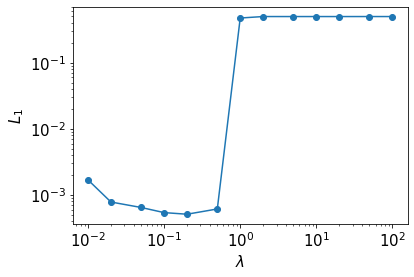

In [7]:
plt.plot(lamb, qqt, marker="o")
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r"$\lambda$",fontsize=15)
plt.ylabel(r"$L_1$",fontsize=15)

In [8]:
# data
n_train = 100
d = 1
x = torch.normal(0,1,size=(n_train,2*d+1))
x = Variable(x, requires_grad=True)
y = -x[:,0]-0.5*x[:,1]

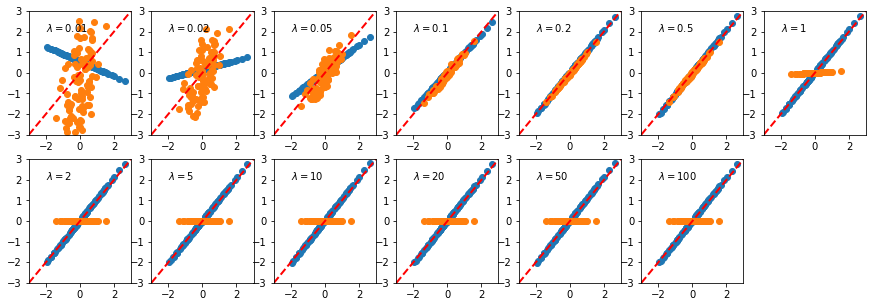

In [9]:
lambs = [0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50,100]
plt.figure(figsize=(15,5))
for i in range(len(lambs)):
    plt.subplot(2,7,i+1)
    superlnn = SUPERLNN(d=1, mode="qqt")
    superlnn.load_state_dict(torch.load("./models/damp/mode_%s_lamb_%.2f_p2"%("qqt", lambs[i])))
    lnn_pred = superlnn.lnn.predict(x[:,:2])[:,0,0]
    base_pred = superlnn.base(x)[:,0]
    plt.scatter(-x[:,0].detach().numpy(),lnn_pred.detach().numpy())
    plt.scatter(-0.5*x[:,1].detach().numpy(),base_pred.detach().numpy())
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.plot([-3,3],[-3,3],ls="--",color="red",linewidth=2)
    plt.text(-2,2,r"$\lambda={}$".format(lambs[i]))